# This Notebook is all about RAG

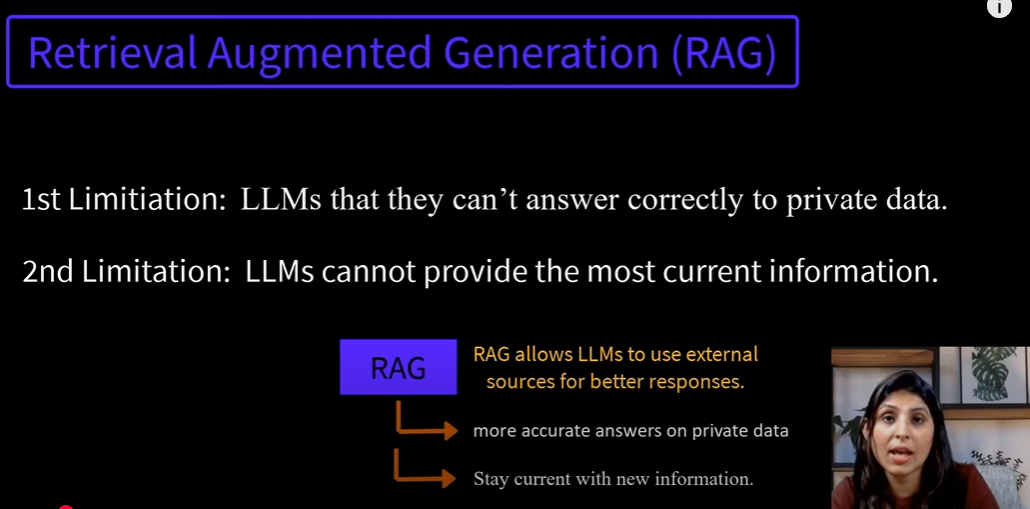

https://github.com/AarohiSingla/Generative_AI/tree/main/L-7/RAG_demo

# FIASS DB Search Index 

Yes, FAISS supports several other distance metrics besides the flat **L2 distance** (Euclidean distance). Here are some common options:

### 1. **Inner Product Distance (Dot Product)**:
   - This measures the similarity based on the dot product of two vectors.
   - Useful for tasks involving cosine similarity when the vectors are normalized.
   - To use it in FAISS:
     ```python
     index = faiss.IndexFlatIP(dim)
     ```
   - **Key Use Case**: Often used for recommendation systems or ranking tasks where high values of similarity are desired.

### 2. **Cosine Similarity**:
   - While FAISS does not natively provide a direct cosine similarity function, you can compute cosine similarity by **normalizing your vectors** (scaling them to unit length) and then using **Inner Product Distance**.
     ```python
     # Normalize embeddings before adding them to the FAISS index
     faiss.normalize_L2(embeds)  # In-place normalization
     index = faiss.IndexFlatIP(dim)
     ```

### 3. **Manhattan Distance (L1 Distance)**:
   - FAISS does not directly support L1 distance, but you can calculate it manually outside of FAISS. For certain applications, you may need custom implementations.

### 4. **Hamming Distance (Binary Vectors)**:
   - For binary data, FAISS supports Hamming distance, which calculates the number of differing bits between two binary strings.
   - To use:
     ```python
     index = faiss.IndexBinaryFlat(dim)
     ```
   - **Key Use Case**: Useful in compact datasets where the data is stored in binary form (e.g., hash tables).

### 5. **Other Custom Distances**:
   - FAISS is mainly optimized for L2 and Inner Product searches. If you want to use other distance metrics (e.g., Mahalanobis distance), you'll need to preprocess the embeddings or write custom extensions outside of FAISS.

Let me know which distance metric you're interested in, and I can help you implement it! 😊

# How does Re-Ranking Work:

Let's look at an **example implementation of a reranker** in Python. We'll use **BM25** for the initial retrieval and a **BERT-based reranker** (via the Hugging Face Transformers library) for refining the ranking of the retrieved documents.

---

### Code: Reranker Example with BM25 and BERT
```python
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from rank_bm25 import BM25Okapi
import string

# Step 1: Corpus (Documents) and Query
texts = [
    "The cat sat on the mat.",
    "Dogs are loyal animals.",
    "The cat is a friendly pet.",
    "Elephants are the largest land animals.",
    "Cats and dogs are common pets."
]
query = "Tell me about cats and dogs."

# Step 2: BM25 Tokenizer
def bm25_tokenizer(text):
    tokenized_doc = []
    for token in text.lower().split():
        token = token.strip(string.punctuation)
        if len(token) > 0:
            tokenized_doc.append(token)
    return tokenized_doc

# Step 3: Initial BM25 Retrieval
tokenized_corpus = [bm25_tokenizer(doc) for doc in texts]
bm25 = BM25Okapi(tokenized_corpus)

bm25_scores = bm25.get_scores(bm25_tokenizer(query))
top_n = 3  # Retrieve top 3 documents
top_indices = sorted(range(len(bm25_scores)), key=lambda i: bm25_scores[i], reverse=True)[:top_n]
bm25_hits = [(texts[i], bm25_scores[i]) for i in top_indices]

print("\nBM25 Results (Top 3):")
for doc, score in bm25_hits:
    print(f"Score: {score:.2f} | Document: {doc}")

# Step 4: BERT-based Reranker
# Load a pretrained BERT model for sequence classification
tokenizer = AutoTokenizer.from_pretrained("cross-encoder/ms-marco-TinyBERT-L-6")
model = AutoModelForSequenceClassification.from_pretrained("cross-encoder/ms-marco-TinyBERT-L-6")

# Prepare pairs of (query, document) for reranking
rerank_inputs = []
for doc, _ in bm25_hits:
    encoded_input = tokenizer.encode_plus(query, doc, return_tensors="pt", truncation=True, max_length=512)
    rerank_inputs.append(encoded_input)

# Get relevance scores from the BERT model
reranked_results = []
with torch.no_grad():
    for i, inputs in enumerate(rerank_inputs):
        outputs = model(**inputs)
        score = torch.sigmoid(outputs.logits).item()  # Get the relevance score
        reranked_results.append((bm25_hits[i][0], score))  # (document, score)

# Sort the reranked results by relevance score
reranked_results = sorted(reranked_results, key=lambda x: x[1], reverse=True)

# Step 5: Final Results
print("\nReranked Results (Top 3):")
for doc, score in reranked_results:
    print(f"Relevance Score: {score:.2f} | Document: {doc}")
```

---

### Explanation:
1. **Initial Ranking with BM25**:
   - The BM25 algorithm retrieves the top `N` documents based on keyword overlap with the query.
   - In this example, we select the **top 3 documents** for reranking.

2. **Reranking with BERT**:
   - A pretrained BERT-based reranker (from Hugging Face) scores the relevance of each document to the query.
   - It uses the `(query, document)` pair to compute a **relevance score** for each document.

3. **Combining Results**:
   - The reranker sorts the top `N` documents by their relevance scores, providing a better-ordered list of results.

---

### Example Input/Output:

#### Input:
- **Query**: `"Tell me about cats and dogs."`
- **Corpus**:
  1. "The cat sat on the mat."
  2. "Dogs are loyal animals."
  3. "The cat is a friendly pet."
  4. "Elephants are the largest land animals."
  5. "Cats and dogs are common pets."

#### BM25 Results (Before Reranking):
```
Score: 2.50 | Document: Cats and dogs are common pets.
Score: 1.20 | Document: The cat is a friendly pet.
Score: 1.10 | Document: The cat sat on the mat.
```

#### Reranked Results (After BERT Reranking):
```
Relevance Score: 0.92 | Document: Cats and dogs are common pets.
Relevance Score: 0.78 | Document: The cat is a friendly pet.
Relevance Score: 0.60 | Document: The cat sat on the mat.
```

---

### Use Case:
- **BM25** is fast and good at quickly narrowing down candidates based on keywords.
- **BERT Reranker** provides more context-aware and accurate ranking, especially for ambiguous or complex queries.

Let me know if you'd like further customizations or explanations! 😊

# How MAP is used as Performance Evaluation metrics in RAG , Search Engines

### **Scoring a Single Query with Average Precision (AP) – Example Explained**

#### **Step 1: Understanding the Task**
- You have a **query**, and your model returns a **ranked list of results**.
- Each result is either **relevant (1)** or **irrelevant (0)**.
- **Goal:** Compute **Average Precision (AP)** to measure how well the relevant items are ranked.

---

### **Example: Calculating AP Manually**
#### **Assume a ranked list of 6 documents for a query:**
| Rank | Retrieved Document | Relevance (1 = relevant, 0 = irrelevant) |
|------|-------------------|--------------------------------------|
| 1    | Doc A            | **1** (relevant)                   |
| 2    | Doc B            | **0** (irrelevant)                 |
| 3    | Doc C            | **1** (relevant)                   |
| 4    | Doc D            | **1** (relevant)                   |
| 5    | Doc E            | **0** (irrelevant)                 |
| 6    | Doc F            | **1** (relevant)                   |

Total relevant documents = **4** (A, C, D, F)

#### **Step 1: Compute Precision at Each Relevant Document**
Precision at rank \( k \) is:

\[
P(k) = \frac{\text{# of relevant documents up to } k}{k}
\]

Now, calculate precision only at relevant ranks:

| Rank | Relevance | Precision @ Rank |
|------|-----------|-----------------|
| 1    | **1**     | **1/1** = 1.00  |
| 3    | **1**     | **2/3** = 0.67  |
| 4    | **1**     | **3/4** = 0.75  |
| 6    | **1**     | **4/6** = 0.67  |

#### **Step 2: Compute Average Precision**
\[
AP = \frac{(1.00 + 0.67 + 0.75 + 0.67)}{4}
\]

\[
AP = \frac{3.09}{4} = 0.7725
\]

**Final AP Score: 0.77 (77%)**

---

### **Python Implementation**
Here’s how you can compute **AP** programmatically:

```python
def average_precision(y_true):
    """
    Compute Average Precision (AP) given the relevance list.
    
    :param y_true: List of 1s (relevant) and 0s (irrelevant), ranked by retrieval order.
    :return: Average Precision (AP) score.
    """
    num_relevant = sum(y_true)  # Total relevant documents
    if num_relevant == 0:
        return 0  # If no relevant documents, AP is 0

    precision_at_k = []
    relevant_count = 0

    for i, rel in enumerate(y_true):
        if rel == 1:
            relevant_count += 1
            precision = relevant_count / (i + 1)  # Precision at rank (i+1)
            precision_at_k.append(precision)

    return sum(precision_at_k) / num_relevant  # Compute AP

# Example usage
y_true = [1, 0, 1, 1, 0, 1]  # Ranked retrieval results
ap_score = average_precision(y_true)
print(f"Average Precision: {ap_score:.4f}")  # Output: 0.7725
```

---

### **How AP is Used in LLMs?**
1. **Retrieval-Augmented Generation (RAG):**
   - Before generating responses, LLMs retrieve documents.
   - AP evaluates **how well relevant documents are ranked**.
   - A higher AP means **better retrieval quality**.

2. **Search Ranking in LLM-based Systems:**
   - Example: AI-powered search engines (like ChatGPT with Bing).
   - AP evaluates **how well LLM ranks search results**.

3. **Fine-Tuning LLMs for Ranking Tasks:**
   - If an LLM is trained for ranking, **AP helps evaluate performance**.

---

### **Conclusion**
- **AP measures ranking quality** by averaging precision at relevant points.
- It’s **widely used** in information retrieval and **LLM retrieval tasks**.
- **Python implementation** helps automate AP evaluation.

Let me know if you need more details! 🚀

# Stuff in RAG Pipepine Chains

In the code snippet you provided:  

```python
rag = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type='stuff',
    retriever=db.as_retriever(),
    chain_type_kwargs={
        "prompt": prompt
    },
    verbose=True
)
```

### **What is `"stuff"` in `chain_type='stuff'`?**
- `"stuff"` is a **chain type** used in LangChain’s `RetrievalQA` module.
- It defines **how** the retrieved documents are passed into the LLM for generating a response.
- The `"stuff"` method **directly concatenates** all retrieved documents into the prompt and feeds them to the LLM.

---

### **Different `chain_type` Options in `RetrievalQA`**
LangChain supports different strategies for handling retrieved documents before passing them to the LLM:

| `chain_type` | Description |
|-------------|-------------|
| **`"stuff"`** | **Concatenates all retrieved documents** and passes them as context to the LLM. |
| **`"map_reduce"`** | First processes each document separately (map step), then combines responses (reduce step). |
| **`"refine"`** | Generates an initial response from the first document, then **iteratively refines** it using subsequent documents. |
| **`"map_rerank"`** | Scores each document separately, ranks them, and selects the best one for the final answer. |

---

### **Why Use `"stuff"`?**
- **Fastest** method but has a limitation: if too many documents are retrieved, it might **exceed the token limit** of the LLM.
- Works best when:
  - **Few documents are retrieved**.
  - **Short text snippets** are used.

If your retrieved documents are large, **consider using `"map_reduce"` or `"refine"`** to avoid truncation.

Would you like an example comparing `"stuff"` vs. `"map_reduce"`? 🚀

## RAG vs Fine Tuning

Great question!

Let’s break this down **in simple terms** first, then give **examples and code**.

---

## 🧠 **RAG vs Fine-Tuning** – Explained Like You’re 5 (but smart)

Imagine you're building a **medical chatbot** — like Dr. GPT — to answer patient questions.

---

### 🅰️ **Fine-Tuning**

“**Teach the model everything up front.**”

#### 🧴 Layman Analogy:

It's like **teaching a doctor everything during medical school**. Once trained, they answer from **memory** — no books, no Google.

#### 📦 Example:

You train the chatbot on 10,000 medical Q\&A examples. After training, it **"remembers"** everything and answers from that.

#### ✅ Pros:

* Fast response (no search).
* Works well on **very specific** types of questions.

#### ❌ Cons:

* Costly to train.
* Hard to update (retrain if guidelines change).
* Might hallucinate or **guess wrong confidently**.

---

### 🅱️ **RAG (Retrieval-Augmented Generation)**

“**Let the model look up the answer from a book.**”

#### 📚 Layman Analogy:

Instead of memorizing everything, the doctor looks up **relevant medical documents** before answering your question.

#### 📦 Example:

User asks: *“What are the side effects of Metformin?”*

The chatbot searches a medical database (e.g., Mayo Clinic text), retrieves relevant passages, and then **uses those to answer**.

#### ✅ Pros:

* Always uses **up-to-date facts**.
* Easy to update (just change the docs).
* Lower training cost (you use a pre-trained model).

#### ❌ Cons:

* Needs fast search infrastructure (e.g., FAISS, Chroma).
* Slightly slower than fine-tuned response.

---

## ✅ When to Use What in Medical Chatbots

| Use Case                                          | RAG         | Fine-Tuning |
| ------------------------------------------------- | ----------- | ----------- |
| Chatbot with large, evolving medical texts        | ✅           | ❌           |
| Small, closed domain chatbot (like only diabetes) | ✅ or ✅+Fine | ✅           |
| Need factual accuracy and transparency            | ✅           | ❌           |
| Low budget / fast prototype                       | ✅           | ❌           |
| Extremely high volume, low-latency usage          | ❌           | ✅           |

---

## 🔬 Now Let's See Code Examples

---

### 🧪 1. **RAG Example (using LangChain + FAISS)**

```python
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains import RetrievalQA
from langchain.llms import OpenAI
from langchain.document_loaders import TextLoader

# Load your medical document
loader = TextLoader("metformin_info.txt")
docs = loader.load()

# Split into chunks
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = splitter.split_documents(docs)

# Create embeddings and vector DB
embedding_model = HuggingFaceEmbeddings(model_name="pritamdeka/BioBERT-mnli-snli")
vectorstore = FAISS.from_documents(chunks, embedding_model)

# RAG chain: user question + retrieved chunks => LLM
qa_chain = RetrievalQA.from_chain_type(
    llm=OpenAI(), 
    retriever=vectorstore.as_retriever()
)

# Ask a question
query = "What are the side effects of Metformin?"
result = qa_chain.run(query)

print("Answer:", result)
```

---

### 🧪 2. **Fine-Tuning Example (on Q\&A pairs using Transformers)**

Here’s a super simplified fine-tuning example using `transformers`:

```python
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments

# Load model & tokenizer
model = T5ForConditionalGeneration.from_pretrained("t5-small")
tokenizer = T5Tokenizer.from_pretrained("t5-small")

# Prepare Q&A fine-tuning data
train_data = [
    {"question": "What are the side effects of Metformin?", 
     "answer": "Nausea, diarrhea, abdominal pain, and vitamin B12 deficiency."},
    {"question": "Can diabetics eat rice?", 
     "answer": "Yes, but in moderation and with portion control."}
]

# Tokenize
def tokenize(example):
    input_text = "question: " + example["question"]
    target_text = example["answer"]
    return tokenizer(input_text, text_target=target_text, truncation=True, padding="max_length", max_length=128)

tokenized_data = [tokenize(e) for e in train_data]

# Dummy dataset (normally you'd use Dataset from HuggingFace Datasets)
from torch.utils.data import Dataset

class MedicalQADataset(Dataset):
    def __init__(self, data): self.data = data
    def __getitem__(self, i): return {k: v for k, v in self.data[i].items()}
    def __len__(self): return len(self.data)

train_dataset = MedicalQADataset(tokenized_data)

# Training
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=2,
    num_train_epochs=3,
    logging_dir="./logs"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
)

trainer.train()

# Ask a question
input_text = "question: What are the side effects of Metformin?"
inputs = tokenizer(input_text, return_tensors="pt")
output = model.generate(**inputs)
print("Answer:", tokenizer.decode(output[0], skip_special_tokens=True))
```

---

## 🧠 Final Thoughts

| Feature                | RAG                       | Fine-Tuning                     |
| ---------------------- | ------------------------- | ------------------------------- |
| Updates Easily?        | ✅ (just update docs)      | ❌ (need to retrain)             |
| Factual Accuracy       | ✅ (if docs are reliable)  | ❌ (can hallucinate)             |
| Cost-Efficient?        | ✅ (uses pretrained model) | ❌ (fine-tuning = \$\$\$ + time) |
| Memory Efficient?      | ✅                         | ✅                               |
| Real-time Medical Q\&A | ✅ Best choice             | ✅ only for narrow use cases     |

---

Would you like me to help you set up a full RAG pipeline with **your own medical PDFs** or try fine-tuning on your own Q\&A dataset?
